# MadMiner tutorial 2: SALLY, Fisher information, and ensemble methods (parton level)

Johann Brehmer, Felix Kling, Kyle Cranmer 2018

In the first tutorial you saw how to set up a process with MadMiner, generate events and turn them into training samples, and construct likelihood ratio estimators from them. Here we introduce some alternative steps which will lead us to an estimator for the score at a reference point (SALLY) and the expected Fisher information. Along the way, we'll introduce some powerful ensemble methods.

If you're not familiar with SALLY, please have a look at ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013)
or, for more details, ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020). For the Fisher information part, see the original publication ["Better Higgs Measurements Through Information Geometry"](https://arxiv.org/abs/1612.05261) or a more detailed, pedagogical introduction in Chapter 4 of ["New Ideas for Effective Higgs Measurements"](https://inspirehep.net/record/1624219).

## Preparations

Make sure you've run the first tutorial before executing this notebook!

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.sampling import SampleAugmenter, constant_benchmark_theta
from madminer.ml import MLForge, EnsembleForge
from madminer.fisherinformation import FisherInformation
from madminer.plotting import plot_fisher_information_contours_2d


MadMiner uses the Python `logging` module to provide additional information and debugging output. You can choose how much of this output you want to see by switching the level in the following lines to `logging.DEBUG` or `logging.WARNING`.

In [2]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. to 5.: see tutorial 1.

We assume that you have run steps 1 through 5 of the first tutorial, and thus have a MadMiner file with observables and event weights ready to go!

## 6. Make (unweighted) training and test samples with augmented data

Again, the next step is handled by the MadMiner class `SampleAugmenter`.

In [3]:
sa = SampleAugmenter('data/madminer_example_shuffled.h5')

11:50 madminer.sampling    INFO    Loading data from data/madminer_example_shuffled.h5
11:50 madminer.sampling    INFO    Found 2 parameters
11:50 madminer.sampling    INFO    Did not find nuisance parameters
11:50 madminer.sampling    INFO    Found 6 benchmarks, of which 6 physical
11:50 madminer.sampling    INFO    Found 2 observables
11:50 madminer.sampling    INFO    Found 6537 events
11:50 madminer.sampling    INFO    Found morphing setup with 6 components


The relevant `SampleAugmenter` function for local score estimators is `extract_samples_train_local()`. As before, for the argument `theta` you can use the helper functions `constant_benchmark_theta()`, `multiple_benchmark_thetas()`, `constant_morphing_theta()`, `multiple_morphing_thetas()`, and `random_morphing_thetas()`.

In [4]:
x, theta, t_xz = sa.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=100000,
    folder='./data/samples',
    filename='train'
)

11:50 madminer.sampling    INFO    Extracting training sample for local score regression. Sampling and score evaluation according to (u'benchmark', u'sm')
11:50 madminer.sampling    INFO    Effective number of samples: 3269.0000000001205


## 7a. Train one network to estimate score and Fisher information

It's now time to build a neural network. Only this time, instead of the likelihood ratio itself, we will estimate the gradient of the log likelihood with respect to the theory parameters -- the score. To be precise, the output of the neural network is an estimate of the score at some reference parameter point, for instance the Standard Model. A neural network that estimates this "local" score can be used to calculate the Fisher information at that point. The estimated score can also be used as a machine learning version of Optimal Observables, and likelihoods can be estimated based on density estimation in the estimated score space. This method for likelihood ratio estimation is called SALLY, and there is a closely related version called SALLINO. Both are explained in ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013) and ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020).

Again, the central object for this is the `madminer.ml.MLForge` class:

In [5]:
forge = MLForge()

### Training

In [6]:
forge.train(
    method='sally',
    x_filename='data/samples/x_train.npy',
    t_xz0_filename='data/samples/t_xz_train.npy',
    verbose="all",
)

forge.save('models/sally')

11:50 madminer.ml          INFO    Starting training
11:50 madminer.ml          INFO      Method:                 sally
11:50 madminer.ml          INFO      Training data:          x at data/samples/x_train.npy
11:50 madminer.ml          INFO                              t_xz (theta0) at data/samples/t_xz_train.npy
11:50 madminer.ml          INFO      Features:               all
11:50 madminer.ml          INFO      Method:                 sally
11:50 madminer.ml          INFO      Hidden layers:          (100, 100, 100)
11:50 madminer.ml          INFO      Activation function:    tanh
11:50 madminer.ml          INFO      Batch size:             200
11:50 madminer.ml          INFO      Optimizer:              amsgrad
11:50 madminer.ml          INFO      Epochs:                 50
11:50 madminer.ml          INFO      Learning rate:          0.001 initially, decaying to 0.0001
11:50 madminer.ml          INFO      Validation split:       0.25
11:50 madminer.ml          INFO      Early stop

11:53 madminer.utils.ml.tr INFO    Epoch  40: train loss  0.07616 (mse_score:  0.076)
11:53 madminer.utils.ml.tr INFO               val. loss   0.07436 (mse_score:  0.074)
11:53 madminer.utils.ml.tr INFO    Epoch  41: train loss  0.07610 (mse_score:  0.076)
11:53 madminer.utils.ml.tr INFO               val. loss   0.07434 (mse_score:  0.074)
11:53 madminer.utils.ml.tr INFO    Epoch  42: train loss  0.07597 (mse_score:  0.076)
11:53 madminer.utils.ml.tr INFO               val. loss   0.07398 (mse_score:  0.074)
11:53 madminer.utils.ml.tr INFO    Epoch  43: train loss  0.07590 (mse_score:  0.076)
11:53 madminer.utils.ml.tr INFO               val. loss   0.07410 (mse_score:  0.074)
11:53 madminer.utils.ml.tr INFO    Epoch  44: train loss  0.07574 (mse_score:  0.076)
11:53 madminer.utils.ml.tr INFO               val. loss   0.07400 (mse_score:  0.074)
11:53 madminer.utils.ml.tr INFO    Epoch  45: train loss  0.07568 (mse_score:  0.076)
11:53 madminer.utils.ml.tr INFO               val. los

### Evaluation

Let's evaluate the SM score on the test data

In [7]:
forge.load('models/sally')

t_hat = forge.evaluate(
    x='data/samples/x_test.npy'
)

Let's have a look at the estimated score and how it is related to the observables:

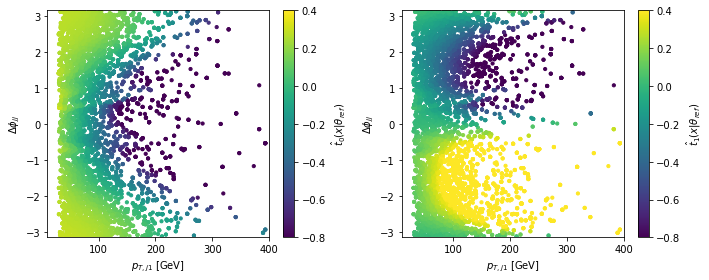

In [8]:
x = np.load('data/samples/x_test.npy')

fig = plt.figure(figsize=(10,4))

for i in range(2):
    
    ax = plt.subplot(1,2,i+1)

    sc = plt.scatter(x[::10,0], x[::10,1], c=t_hat[::10,i], s=10., cmap='viridis', vmin=-0.8, vmax=0.4)
    cbar = plt.colorbar(sc)

    cbar.set_label(r'$\hat{t}_' + str(i) + r'(x | \theta_{ref})$')
    plt.xlabel(r'$p_{T,j1}$ [GeV]')
    plt.ylabel(r'$\Delta \phi_{jj}$')
    plt.xlim(10.,400.)
    plt.ylim(-3.15,3.15)
    
plt.tight_layout()
plt.show()


### Fisher information

In addition, we can use SALLY estimators to estimate the expected Fisher information.

In [9]:
fisher = FisherInformation('data/madminer_example_shuffled.h5')

11:53 madminer.fisherinfor INFO    Loading data from data/madminer_example_shuffled.h5
11:53 madminer.fisherinfor INFO    Found 2 parameters
11:53 madminer.fisherinfor WARNING Did not find nuisance parameters!
11:53 madminer.fisherinfor INFO    Found 6 benchmarks, of which 6 physical
11:53 madminer.fisherinfor INFO    Found 2 observables: pt_j1, delta_phi_jj
11:53 madminer.fisherinfor INFO    Found 6537 events
11:53 madminer.fisherinfor INFO    Found morphing setup with 6 components


In [10]:
fisher_information, _ = fisher.calculate_fisher_information_full_detector(
    theta=[0.,0.],
    model_file='models/sally',
    unweighted_x_sample_file='data/samples/x_test.npy',
    luminosity=3000000.
)

print('Kinematic Fisher information after 3000 ifb:\n{}'.format(fisher_information))

11:53 madminer.fisherinfor INFO    Evaluating rate Fisher information
11:53 madminer.utils.inter WARNING include_nuisance_parameters=False without benchmark_is_nuisance information. Returning all weights.


Kinematic Fisher information after 3000 ifb:
[[70.14907905 15.70474489]
 [15.70474489 68.36131458]]


We can visualize the Fisher information with contours:

/Users/johannbrehmer/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'label'
  s)
/Users/johannbrehmer/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


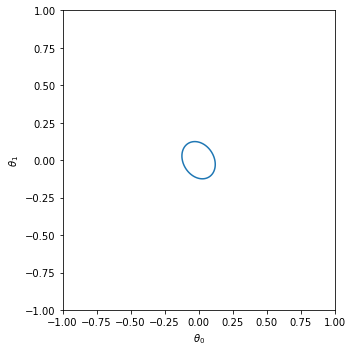

In [11]:
_ = plot_fisher_information_contours_2d(
    [fisher_information],
    xrange=(-1,1),
    yrange=(-1,1)
)

## 7b. Ensemble methods

Instead of using a single neural network to estimate the likelihood ratio, score, or Fisher information, we can use an ensemble of such estimators. That provides us with a more reliable mean prediction as well as a measure of the uncertainty. The class `madminer.ml.EnsembleForge` automates this process. Currently, it only supports SALLY estimators:

In [15]:
ensemble = EnsembleForge(estimators=5)

### Training

The `EnsembleForge` object has very similar functions as `MLForge`. In particular, we can train all estimators simultaneously with `train_all()` and save the ensemble to files:

In [16]:
ensemble.train_all(
    method='sally',
    x_filename='data/samples/x_train.npy',
    t_xz0_filename='data/samples/t_xz_train.npy',
    n_epochs=10,
)

ensemble.save('models/sally_ensemble')

11:54 madminer.ml          INFO    Training 5 estimators in ensemble
11:54 madminer.ml          INFO    Training estimator 1 / 5 in ensemble
11:54 madminer.ml          INFO    Starting training
11:54 madminer.ml          INFO      Method:                 sally
11:54 madminer.ml          INFO      Training data:          x at data/samples/x_train.npy
11:54 madminer.ml          INFO                              t_xz (theta0) at data/samples/t_xz_train.npy
11:54 madminer.ml          INFO      Features:               all
11:54 madminer.ml          INFO      Method:                 sally
11:54 madminer.ml          INFO      Hidden layers:          (100, 100, 100)
11:54 madminer.ml          INFO      Activation function:    tanh
11:54 madminer.ml          INFO      Batch size:             200
11:54 madminer.ml          INFO      Optimizer:              amsgrad
11:54 madminer.ml          INFO      Epochs:                 10
11:54 madminer.ml          INFO      Learning rate:          0.001 in

11:55 madminer.ml          INFO    Found 100000 samples with 2 parameters and 2 observables
11:55 madminer.ml          INFO    Rescaling inputs
11:55 madminer.ml          INFO    Creating model for method sally
11:55 madminer.ml          INFO    Training model
11:56 madminer.utils.ml.tr INFO    Epoch   1: train loss  0.13724 (mse_score:  0.137)
11:56 madminer.utils.ml.tr INFO               val. loss   0.11112 (mse_score:  0.111)
11:56 madminer.utils.ml.tr INFO    Epoch   2: train loss  0.10583 (mse_score:  0.106)
11:56 madminer.utils.ml.tr INFO               val. loss   0.10091 (mse_score:  0.101)
11:56 madminer.utils.ml.tr INFO    Epoch   3: train loss  0.10046 (mse_score:  0.100)
11:56 madminer.utils.ml.tr INFO               val. loss   0.09737 (mse_score:  0.097)
11:56 madminer.utils.ml.tr INFO    Epoch   4: train loss  0.09774 (mse_score:  0.098)
11:56 madminer.utils.ml.tr INFO               val. loss   0.09451 (mse_score:  0.095)
11:56 madminer.utils.ml.tr INFO    Epoch   5: train

11:58 madminer.utils.ml.tr INFO    Epoch   8: train loss  0.09235 (mse_score:  0.092)
11:58 madminer.utils.ml.tr INFO               val. loss   0.09164 (mse_score:  0.092)
11:58 madminer.utils.ml.tr INFO    Epoch   9: train loss  0.09163 (mse_score:  0.092)
11:58 madminer.utils.ml.tr INFO               val. loss   0.09133 (mse_score:  0.091)
11:58 madminer.utils.ml.tr INFO    Epoch  10: train loss  0.09127 (mse_score:  0.091)
11:58 madminer.utils.ml.tr INFO               val. loss   0.09110 (mse_score:  0.091)
11:58 madminer.utils.ml.tr INFO    Early stopping did not improve performance


### Evaluation

We can evaluate the ensemble similarly to the individual networks. Let's stick to the estimation of the Fisher information. There are two different ways to take the ensemble average:

- `mode='information'`: We can calculate the Fisher information for each estimator in the ensemble, and then take the mean and the covariance over the ensemble. This has the advantage that it provides a direct measure of the uncertainty of the prediction.
- `mode='score'`: We can calculate the score for each event and estimator, take the ensemble mean for the score of each event, and then calculate the Fisher information based on the mean scores. This is expected to be more precise (since the score estimates will be more precise, and the nonlinearity in the Fisher info calculation amplifies any error in the score estimation). But calculating the covariance in this approach is computationally not feasible, so there will be no error bands.

By default, MadMiner uses the 'score' mode. Here we will use the 'information' mode just to show the nice uncertainty bands we get.

In [ ]:
fisher = FisherInformation('data/madminer_example_shuffled.h5')

fisher_information_mean, fisher_information_covariance = fisher.calculate_fisher_information_full_detector(
    theta=[0.,0.],
    model_file='models/sally_ensemble',
    luminosity=3000000.,
    mode='information'
)

The covariance can be propagated to the Fisher distance contour plot easily:

In [ ]:
_ = plot_fisher_information_contours_2d(
    [fisher_information_mean],
    [fisher_information_covariance],
    xrange=(-1,1),
    yrange=(-1,1)
)

That's the end of the second part of this tutorial. If you have questions, please have a look at the papers, the module documentation, or drop us an email.